In [ ]:
import sys
sys.path.append("/home/ubuntu/mlab/days/w3d3/rl_env/lib/python3.8/site-packages")
sys.path.append("/home/ubuntu/mlab/days/w3d3/rl_env/lib/python3.9/site-packages")

In [ ]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from IPython.display import Video
from video_recorder import VideoRecorder
import torch
from torch import nn
from tqdm import tqdm

import rl_tests

from collections import deque
from dataclasses import dataclass
import random
import typing

In [ ]:
devices = [f'cuda:{i}' for i in [0, 1, 2, 3]]

In [ ]:
env_name = "CartPole-v1"
# env_name = 'MountainCarContinuous-v0'
record = True
video_name = "test_0"

env = gym.make(env_name)
state = env.reset()
done = False
total_reward = 0
video_recorder = VideoRecorder(env, base_path=f'videos/{video_name}')

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

states = 0
while not done:
    states += 1
    if record:
        video_recorder.capture_frame()
    else:  
        show_state(env)
    state, reward, done, _ = env.step(env.action_space.sample()) # Take a random action
    total_reward += reward

print(f"total reward: {total_reward}")
if record:
    video_recorder.close()

total reward: 19.0


In [ ]:
# Display a saved video 
Video("videos/test_0.mp4")

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_size : int, hidden_size : int, out_size : int) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
        )

    # obs: Tensor[..., obs_shape]) -> Tensor[..., num_actions]
    def forward(self, obs):
        return self.layers(obs)
    
rl_tests.test_q_net(MLP)

test_q_net MATCH!!!!!!!!
 SHAPE (16, 19) MEAN: 0.0416 STD: 0.1248 VALS [0.06327 -0.1194 -0.1222 -0.04663 0.1556 0.1193 0.01654 0.009215 0.008495 0.2181...]


In [ ]:
cartpole_env = gym.make("CartPole-v1")
cartpole_eval_env = gym.make("CartPole-v1")

In [ ]:
def make_choice(
    env: gym.Env, eps: float, net: nn.Module, obs, device: str
) -> int:
    if random.random() < eps:
        return env.action_space.sample()
    action_scores = net(torch.tensor(obs, dtype=torch.float32, device=device))
    best_action = action_scores.argmax(dim=-1)
    return best_action.item()

In [ ]:
def evaluate(model: nn.Module, env: gym.Env, eps: float, device: str, video_name = None) -> float:
    # env.reset() returns an initial observation, so make sure to do this at the beginning.
    # Feel free to modify the above function by adding arguments like epsilon : float, device : string, save_video : bool.
    # This is an eval function; make sure you’re not storing gradients
    # Note that env.step takes an action (an int between 0 and env.action_space.n - 1, inclusive) and returns:
    #   state: Tensor  The next observation
    #   reward: float  The reward gained during the timestep
    #   done: bool  Whether or not the episode is over
    #   info: dict  extra information like number of lives remaining
    #   You’ll need to handle the ‘done’ output by exiting the loop when the episode ends.
    
    is_recording = video_name is not None
    if is_recording:
        video_recorder = VideoRecorder(env, base_path=f'videos/{video_name}')  
    
    state = env.reset()
    done = False
    total_reward = 0
    states = 0
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        while not done:
            states += 1
            if is_recording:
                video_recorder.capture_frame()
            action = make_choice(env=env, eps=eps, net=model, obs=state, device=device)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            
    if is_recording:
        video_recorder.close()

    return total_reward

(in_size,) = cartpole_env.observation_space.shape
cartpole_q_net = MLP(in_size=in_size, hidden_size=64, out_size=cartpole_env.action_space.n)
evaluate(model=cartpole_q_net, env=cartpole_env, eps=0.05, device=devices[0], video_name="cartpole-eval")

10.0

In [ ]:
Video(f"videos/cartpole-eval.mp4")

In [ ]:
(in_size,) = cartpole_env.observation_space.shape
device = devices[0]
cartpole_q_net = MLP(in_size=in_size, hidden_size=64, out_size=cartpole_env.action_space.n).to(device)

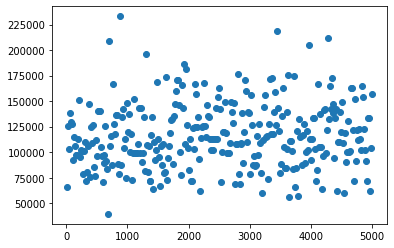

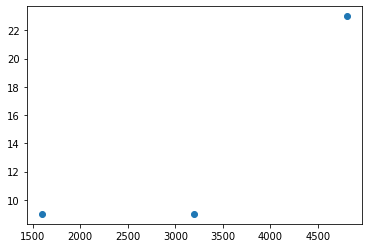

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 18337/20000 [00:49<00:04, 377.05it/s] 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 18289/20000 [00:49<00:04, 374.27it/s] 91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 18241/20000 [00:49<00:04, 372.67it/s] 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 18193/20000 [00:49<00:04, 372.06it/s] 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 18145/20000 [00:49<00:05, 370.35it/s] 90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 18097/20000 [00:49<00:05, 366.11it/s] 90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 18049/20000 [00:48<00:05, 369.42it/s] 90%|█

In [265]:
@dataclass
class TrainConfig:
    train_freq: int
    eval_freq: int
    batch_size: int
    eps: float
    discount_rate: float
    max_experiences: int
    lr: float
    n_steps: int

@dataclass
class Experience:
    state: any # something from the observation space
    action: any # something from the action space
    state_after: any # something from the observation space
    reward: int
    done: bool
    
def reward_from_experience(experience, model, discount_rate, device):
    if experience.done:
        return experience.reward
    else:
        with torch.no_grad():
            predicted_values_of_actions = model(torch.tensor(experience.state_after, dtype=torch.float32, device=device))
        future_reward = torch.max(predicted_values_of_actions)
        return experience.reward + discount_rate * future_reward
    
def batched_reward_from_experience(samples, model, discount_rate, device):
    with torch.no_grad():
        state_afters = torch.stack([
                torch.tensor(sample.state_after, dtype=torch.float32, device=device) for sample in samples
            ],
            dim=0)
        predicted_values_of_actions = model(state_afters)
        future_rewards = predicted_values_of_actions.max(dim=1).values
    reward = torch.tensor([sample.reward for sample in samples], dtype=torch.float32, device=device)
    not_done = torch.tensor([not sample.done for sample in samples], dtype=torch.bool, device=device)
    reward[not_done] += discount_rate * future_rewards[not_done]
    return reward        

def training_loop(
        model: nn.Module, 
        train_env: gym.Env,
        eval_env: gym.Env,
        config: TrainConfig,
        device: str,
):
    model.train()
    losses = []
    evaluations = []
    opt = torch.optim.Adam(model.parameters(), lr=config.lr)
    experiences = deque(maxlen=config.max_experiences)
    state = env.reset()
    for action_idx in range(config.n_steps):
        action = make_choice(env=env, eps=config.eps, net=model, obs=state, device=device)
        state_after, reward, done, _ = env.step(action)
        experiences.append(Experience(state, action, state_after, reward, done))
        state = state_after
        if done:
            obs = env.reset()
        if action_idx != 0 and action_idx % config.train_freq == 0:  # train the model
            samples = random.choices(experiences, k=config.batch_size)
            input_batch = torch.tensor([sample.state for sample in samples], dtype=torch.float32, device=device)
            opt.zero_grad()
            rewards_predicted = model(input_batch)
            assert rewards_predicted.shape == (config.batch_size, env.action_space.n)
            rewards_from_experience = batched_reward_from_experience(samples, model, config.discount_rate, device)
            target_indices = torch.tensor([sample.action for sample in samples], device=device).unsqueeze(1)
            target_batch = torch.gather(rewards_predicted, dim=1, index=target_indices).squeeze(0)
            #print(f"{input_batch=}\n{rewards_predicted=}\n{target_indices=}\n{target_batch=}\n{rewards_from_experience=}")
            loss = torch.sum((target_batch - rewards_from_experience) ** 2)
            losses.append((action_idx, loss.item()))
            loss.backward()
            opt.step()
            if (action_idx // config.train_freq) % config.eval_freq == 0:
                reward = evaluate(model=model, env=eval_env, eps=config.eps, device=device)
                evaluations.append((action_idx, reward))
                model.train()
                
    plt.scatter([i for i, _ in losses], [loss for _, loss in losses])
    plt.show()
    plt.scatter([i for i, _ in evaluations], [r for _, r in evaluations])
    plt.show()
            
training_config = TrainConfig(
    train_freq=16,
    eval_freq=100,
    batch_size=128,
    eps=0.05,
    discount_rate=0.98,
    max_experiences=10000,
    lr=1e-3,
    n_steps=5000,
)
training_loop(model=cartpole_q_net, train_env=cartpole_env, eval_env=cartpole_eval_env, config=training_config, device=device)

In [ ]:
xx = torch.arange(9).reshape(3, 3)
print(xx)
indices = torch.tensor([1,2])
xx[torch.arange(indices.shape[0]), indices]

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


tensor([1, 5])